<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Разделение-выборок" data-toc-modified-id="Разделение-выборок-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Разделение выборок</a></span></li><li><span><a href="#Стандартизация" data-toc-modified-id="Стандартизация-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Стандартизация</a></span></li><li><span><a href="#Кодирование-категориальных-переменных" data-toc-modified-id="Кодирование-категориальных-переменных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Кодирование категориальных переменных</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Балансировка" data-toc-modified-id="Балансировка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Балансировка</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. 

Дополнительно измерим *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [22]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import pandas_profiling
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

In [24]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [5]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Что мы имеем:
* Семь категориальных и семь количественных значений. 
* В числовых значениях Возраста, Срока клиентского обслуживания, Кредитного рейтинга, Баланса на счете, Количества продуктов и Зарплата содержатся данные различного порядка - проведем стандартизацию этих величин
* Значение фамилии и ID пользователя и номера записи дает только справочную информацию для интерпретации результатов, но для наших целей обучения модели и предсказания, в набор признаков включать этот параметр не будем, т.к. фамилия не может являться значимым для прогнозов отказа от продуктов, параметром. Помимо того, нам понадобится кодирование этих значений, что может внести дополнительные вероятности для ошибки при усложнении признаков. Также, Значение фимилии является признаком с высокой мощностью, и его кодирование потребует больших ресурсов, затраченных впустую. 
* Имеются пропуски в столбце с данными и о сроках обслуэивания "Tenure" и их всего 9% - эти данные заполним нулями, т.к. отсутствие информации о количестве лет клиентского стажа, вероятно, означает его отсутствие.
* Названия столбцов стоит привести к нижнему регистру
* Кредитный рейтинг распределен нормально, но имеются выбросы на максимальных значениях. 
* Значения возраста распределены нормально, но с характерными промежуточными впадинами. 
* Значения баланса распределены нормально, но с очевидным выбросом в районе нулевых значений. 


Способы кодирования категориальных переменных:
* Территориальный признак (Страна) и пол. Кодирование используем OHE для Логистической регрессии, а для случайного леса, дополнительно рассмотрим вариант с OrdinalEncoder.  
* Количество используемых продуктов банка (NumOfProducts), по сути является категориальными значениями, однако, каждая категоория - это число. Нет смысла проводить дополнительных итерация по кодированию, достаточно использовать текущие значения в формате Int. Так как данные здесь порядковые, и вес самого числа имеет значение (важно что клиент с большим числом продуктов более вовлечен в отношения с банком), не будем допонительно кодировать эти значения с помощью OHE. 
* Срок работы с банком (Tenure) можно также воспринимать как категориальный признак без кодирования OHE аналогично количеству продуктов, но стоит перевести его в Int, т.к. значения могут быть только целочисленные. 

Гипотезы:
* На факт ухода из банка, вероятно (исходя из оценки кореляций) оказывают сильное влияние два фактора - Возраст и количество используемых продуктов. 
* Баланс и территориальный признак (Geografy) кореллируют. Если бы стран было гораздо больше чем три, или этот признак был более детализированным, стоило бы проверить модель с учетом потенциальной мультиколлинеарности путем удаления одного из кореллирующих столбцов, но не в нашем случае. 




In [25]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [26]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [27]:
df.columns = df.columns.str.lower()

df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [28]:
df = df.rename(
    columns=
    {
        'creditscore': 'credit_score',
        'numofproducts': 'num_of_products',
        'hascrcard': 'has_cr_card',
        'isactivemember': 'is_active_member',
        'estimatedsalary': 'estimated_salary'
    }
) 

df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [29]:
df['tenure'] = df['tenure'].fillna(0)

In [30]:
df['tenure'] = df['tenure'].astype('int')
df['age'] = df['age'].astype('int')

### Баланс классов

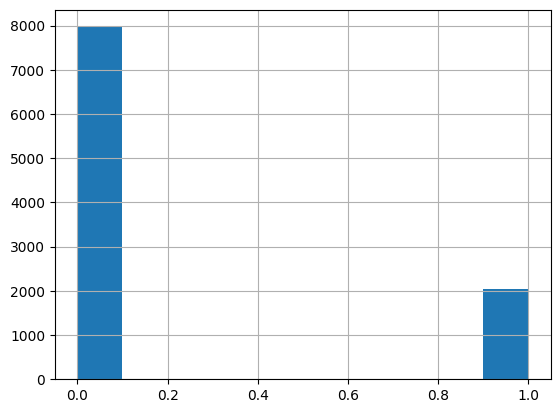

In [31]:
%matplotlib inline

df['exited'].hist()

plt.show()

В нашем таргете наблюдается явный дисбаланс. Для начала будем учитывать это при разделении выборок, и использовать стратификацию по таргету. 

### Разделение выборок

Для удобства будем использовать заранее подготовленную функцию разделения со стратификацией, которая будет принимать на вход датафрейм и параметр 'part', который опредеяет какой набор мы получим на выходе - train, valid или test. 

In [32]:
def splitter(data, part='all'):
    features = data.drop(['exited'], axis=1) 
    target = data['exited']

    features_train, features_valid_test, target_train, target_valid_test = \
    train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

    features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)
    
    if part == 'train':
        return features_train, target_train
    elif part == 'valid':
        return features_valid, target_valid
    elif part == 'test':
        return features_test, target_test
    elif part == 'all':
        return features_train, target_train, features_valid, target_valid, features_test, target_test

### Стандартизация

Напишем функцию, которая будет принимать на вход признаки, а на выходе их масштабированный вариант

In [33]:
def scaler(features):
    num_df = features.loc[:, ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure', 'num_of_products']]

    scaler = StandardScaler()
    scaler_df = pd.DataFrame(data=scaler.fit_transform(num_df), index=features.index, columns=num_df.columns) 
    scaler_df = pd.concat(
        (
            scaler_df, features.drop(
                ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure', 'num_of_products'], axis=1
            )
        ), axis=1
    )
    return scaler_df

### Кодирование категориальных переменных

Напишем функцию, которая будет принимать на вход признаки, а на выходе их кодированный вариант с возможностью выбора типа кодирования ohe или ordinal:

In [39]:
def cater(features, coder):
    if coder == 'ohe':
        transformer = make_column_transformer(
            (OneHotEncoder(drop='if_binary'), ['gender', 'geography']),
            remainder='passthrough'
        )
        ohe = transformer.fit_transform(features)
        ohe_df = pd.DataFrame(data=ohe, index=features.index, columns=transformer.get_feature_names_out())

        return ohe_df
    
    elif coder == 'ordinal':
        cat_df = features.loc[:, ['gender', 'geography']]
        encoder = OrdinalEncoder()
        ordinal_df = pd.DataFrame(data=encoder.fit_transform(cat_df), index=features.index, columns=cat_df.columns) 
        ordinal_df = pd.concat((ordinal_df, features.drop(['gender', 'geography'], axis=1)), axis=1)
        
        return ordinal_df

In [40]:
cater(scaler(splitter(df, part='train')[0]), coder='ohe')

onehotencoder__gender_Male  onehotencoder__geography_France  \
2837                         0.0                              0.0   
9925                         0.0                              1.0   
8746                         1.0                              1.0   
660                          0.0                              0.0   
3610                         0.0                              1.0   
...                          ...                              ...   
6172                         1.0                              0.0   
2360                         0.0                              0.0   
4499                         0.0                              0.0   
9162                         1.0                              0.0   
700                          0.0                              1.0   

      onehotencoder__geography_Germany  onehotencoder__geography_Spain  \
2837                               1.0                             0.0   
9925                               0.0                             0.0   
8746                               0.0                             0.0   
660                                1.0                             0.0   
3610                               0.0                             0.0   
...                                ...                             ...   
6172                               1.0                             0.0   
2360                               1.0                             0.0   
4499                               1.0                             0.0   
9162                               1.0                             0.0   
700                                0.0                             0.0   

      remainder__credit_score  remainder__age  remainder__balance  \
2837                -1.040434        0.953312            0.774657   
9925                 0.454006       -0.095244            1.910540   
8746                 0.103585       -0.476537            0.481608   
660                 -0.184996        0.190726            0.088439   
3610                -0.720933        1.620574            0.879129   
...                       ...             ...                 ...   
6172                -0.844611        0.381372            0.180068   
2360                -1.359935        0.190726            0.547724   
4499                -1.174418        0.476696            0.727840   
9162                 0.155118        2.287837            0.449382   
700                  1.031168       -0.667183           -1.219673   

      remainder__estimated_salary  remainder__tenure  \
2837                    -0.119110           0.467449   
9925                    -0.258658          -1.461501   
8746                     1.422836           1.110432   
660                     -1.160427          -1.461501   
3610                     0.113236          -1.140009   
...                           ...                ...   
6172                     0.117350           0.145957   
2360                    -0.192524           0.145957   
4499                     0.531933          -0.175534   
9162                    -1.307769          -1.461501   
700                     -0.083302           0.145957   

      remainder__num_of_products  remainder__has_cr_card  \
2837                   -0.914708                     0.0   
9925                   -0.914708                     1.0   
8746                    0.820981                     0.0   
660                    -0.914708                     1.0   
3610                   -0.914708                     1.0   
...                          ...                     ...   
6172                    4.292357                     1.0   
2360                   -0.914708                     1.0   
4499                   -0.914708                     0.0   
9162                   -0.914708                     1.0   
700                     0.820981                     1.0   

      remainder__is_active_member  
2837                         

Объединим все подготовительные функции в единую для разделения выборок сразу со всеми изменениями:

In [41]:
def coded_splitter(data, part='all', coder='ohe'):
    features = data.drop(['exited'], axis=1) 
    target = data['exited']

    features_train, features_valid_test, target_train, target_valid_test = \
    train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

    features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)
    
    features_train = cater(scaler(features_train), coder=coder)
    features_valid = cater(scaler(features_valid), coder=coder)
    features_test = cater(scaler(features_test), coder=coder)
         
    if part == 'train':
        return features_train, target_train
    elif part == 'valid':
        return features_valid, target_valid
    elif part == 'test':
        return features_test, target_test
    elif part == 'all':
        return features_train, target_train, features_valid, target_valid, features_test, target_test

In [42]:
coded_splitter(df, part='train', coder='ohe')[0].head()

onehotencoder__gender_Male  onehotencoder__geography_France  \
2837                         0.0                              0.0   
9925                         0.0                              1.0   
8746                         1.0                              1.0   
660                          0.0                              0.0   
3610                         0.0                              1.0   

      onehotencoder__geography_Germany  onehotencoder__geography_Spain  \
2837                               1.0                             0.0   
9925                               0.0                             0.0   
8746                               0.0                             0.0   
660                                1.0                             0.0   
3610                               0.0                             0.0   

      remainder__credit_score  remainder__age  remainder__balance  \
2837                -1.040434        0.953312            0.774657   
9925                 0.454006       -0.095244            1.910540   
8746                 0.103585       -0.476537            0.481608   
660                 -0.184996        0.190726            0.088439   
3610                -0.720933        1.620574            0.879129   

      remainder__estimated_salary  remainder__tenure  \
2837                    -0.119110           0.467449   
9925                    -0.258658          -1.461501   
8746                     1.422836           1.110432   
660                     -1.160427          -1.461501   
3610                     0.113236          -1.140009   

      remainder__num_of_products  remainder__has_cr_card  \
2837                   -0.914708                     0.0   
9925                   -0.914708                     1.0   
8746                    0.820981                     0.0   
660                    -0.914708                     1.0   
3610                   -0.914708                     1.0   

      remainder__is_active_member  
2837                          1.0  
9925                          1.0  
8746                          1.0  
660                           1.0  
3610                          0.0

In [46]:
coded_splitter(df, part='train', coder='ohe')[0].isna().sum()

onehotencoder__gender_Male          0
onehotencoder__geography_France     0
onehotencoder__geography_Germany    0
onehotencoder__geography_Spain      0
remainder__credit_score             0
remainder__age                      0
remainder__balance                  0
remainder__estimated_salary         0
remainder__tenure                   0
remainder__num_of_products          0
remainder__has_cr_card              0
remainder__is_active_member         0
dtype: int64

In [43]:
coded_splitter(df, part='train', coder='ordinal')[0].head()

gender  geography  credit_score       age   balance  estimated_salary  \
2837     0.0        1.0     -1.040434  0.953312  0.774657         -0.119110   
9925     0.0        0.0      0.454006 -0.095244  1.910540         -0.258658   
8746     1.0        0.0      0.103585 -0.476537  0.481608          1.422836   
660      0.0        1.0     -0.184996  0.190726  0.088439         -1.160427   
3610     0.0        0.0     -0.720933  1.620574  0.879129          0.113236   

        tenure  num_of_products  has_cr_card  is_active_member  
2837  0.467449        -0.914708            0                 1  
9925 -1.461501        -0.914708            1                 1  
8746  1.110432         0.820981            0                 1  
660  -1.461501        -0.914708            1                 1  
3610 -1.140009        -0.914708            1                 0

## Исследование задачи

### Случайный лес

Для задачи подбора модели напишем функцию, которая будет на вход принимать набор данных а на выходе отдавать, интрересуюзщие нас, метрики качества модели - f1-меру, матрицу ошибок, площадь под кривой AUC-ROC и саму кривую. Тело функции предусматривает перебор основных гиперпараметров случайного леса и выбор оптимальной модели путем сравнения f1 мер. Заранее предусмотрим управление параметром веса класс для включения балансировки и управление размером выборки для дальнейших исследований. Значение параметров функции:
* data - входящие данные
* coder - выбор метода кодировани ohe или ordinal
* balance - включение балансировки классов. По умолчанию None.
* sample - увеличение или уменьшение выборки. от 0 до 1 доля уменьшения количества отрицательных ответов. От 1 и выше коэфециент увеличения положительных ответов. По умолчанию "1" - без изменений
* testing - выдачача тестовых выборок параметров и таргета без обучения и поиска гиперпараметров. По умолчанию False.

In [44]:
def grid_hyp(data, coder, balance=None, sample=1, testing=False):
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 30)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(1, 50, num = 20)]
    min_samples_split = [2, 6, 12, 15]
    min_samples_leaf = [1, 3, 4, 6]
    bootstrap = [True, False]

    
    grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }  
    
    features_train, target_train, features_valid, target_valid, features_test, target_test = \
    coded_splitter(data, part='all', coder=coder)
    
    if testing == True:
        return features_test, target_test
    
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    if sample > 1:
        
        features_upsampled = pd.concat([features_zeros] + [features_ones] * sample)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * sample)

        features_upsampled, target_upsampled = shuffle(
            features_upsampled, target_upsampled, random_state=12345)

        features_train, target_train = features_upsampled, target_upsampled
        
    elif sample < 1:
        
        features_downsampled = pd.concat(
            [features_zeros.sample(frac=sample, random_state=12345)] + [features_ones])
        target_downsampled = pd.concat(
            [target_zeros.sample(frac=sample, random_state=12345)] + [target_ones])

        features_downsampled, target_downsampled = shuffle(
            features_downsampled, target_downsampled, random_state=12345)

        features_train, target_train = features_downsampled, target_downsampled
        
    search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state = 123456, class_weight=balance),
        param_distributions = grid,
        n_iter = 100, cv = 5, verbose=0, random_state=35, n_jobs = -1,
        
    )
    
    search.fit(features_train, target_train)
    final_model = search.best_estimator_
    predicted_valid = search.best_estimator_.predict(features_valid)
    
    probabilities_valid = final_model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.])
    plt.xlim([0.0, 1])
    plt.title("ROC-кривая")

    print (
        'Лучшие параметры:', search.best_params_, '\n',
        'confusion_matrix \n', confusion_matrix(target_valid, predicted_valid),'\n',
        'F1 на этой моделе:', f1_score(target_valid, predicted_valid), '\n',
        'AUC_ROC:', auc_roc
    )  
    plt.show()
        
    return final_model

Вот что получим для датафрейма, с OHE-кодировщиком:

C:\Users\klyuchevenko.e\Desktop\DS\ya\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\klyuchevenko.e\Desktop\DS\ya\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\klyuchevenko.e\Desktop\DS\ya\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\klyuchevenko.e\Desktop\DS\ya\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constrain

Лучшие параметры: {'n_estimators': 84, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 19, 'bootstrap': True} 
 confusion_matrix 
 [[1539   53]
 [ 210  198]] 
 F1 на этой моделе: 0.6009104704097117 
 AUC_ROC: 0.8716576140506453


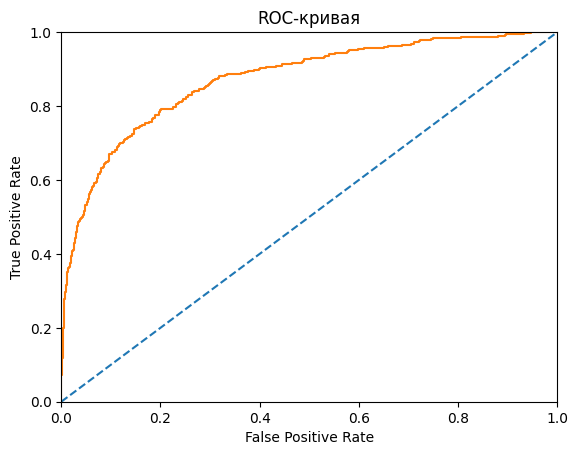

In [45]:
ohe_model = grid_hyp(df, coder='ohe')

In [21]:
ohe_model

RandomForestClassifier(max_depth=19, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=12, n_estimators=84,
                       random_state=123456)

для Ordinal Coding:

Лучшие параметры: {'n_estimators': 62, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': True} 
 confusion_matrix 
 [[1542   50]
 [ 221  187]] 
 F1 на этой моделе: 0.57984496124031 
 AUC_ROC: 0.8690203468322002


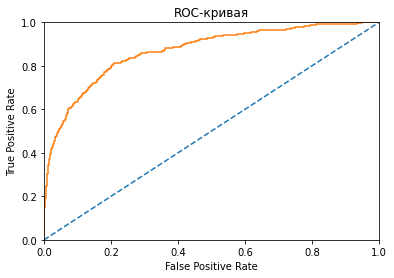

In [22]:
ord_model = grid_hyp(df, coder='ordinal')

Для случайного леса лучше отработали данные, кодированные OHE - для логистической регрессии этот вариант тоже будет предпочтительнее, поэтому, далее будем работать только с OHE. В целом, показатели f1 для случайного леса на валидационной выборке и при подборе оптимальных параметров, уже удовлетворяют целевому значению проекта >0.59, но постараемся улучшить этот показатель. Проверим как справится логистрическая регрессия:

### Логистическая регрессия

In [23]:
features_train, target_train = coded_splitter(df, part='train', coder='ohe')
features_valid, target_valid = coded_splitter(df, part='valid', coder='ohe')
features_test, target_test = coded_splitter(df, part='test', coder='ohe')

In [24]:
best_model = None
best_result = 0

for max_c in range(1, 100, 1):
    model = LogisticRegression(
        C=max_c,
        random_state=123456
    ) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)    
    result = f1_score(target_valid, predicted_valid) 
    
    if result > best_result:
        best_model = max_c
        best_result = result
    
    
print(
        'Набор лучших параметров:', best_model, '\n',
        'F1 на этих параметрах:', f1_score(target_valid, predicted_valid), '\n'
)

Набор лучших параметров: 3 
 F1 на этих параметрах: 0.3132969034608379 



Для перебора параметров нет смысла создавать отдельную фунцию - единственный параметр, который имеет смысл подвергать итерации - это 'C'. После перебора вариантов обычным циклом, не удалось поднять f1 выше 0,31. Такая модель нам не годится. 

Итак, для наших целей больше всего подходит модель случайного леса с оптимальными параметры, которые удалось подобрать перебором (f1 - 0.62). Будем испольщовать эту модель далее, улучшая показатель f1. 

## Борьба с дисбалансом

### Балансировка

Попробуем включить балансировку в заранее предусмотренном параметре нашей функции:

Лучшие параметры: {'n_estimators': 87, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 19, 'bootstrap': True} 
 confusion_matrix 
 [[1529   63]
 [ 218  190]] 
 F1 на этой моделе: 0.5748865355521936 
 AUC_ROC: 0.8652707471179427


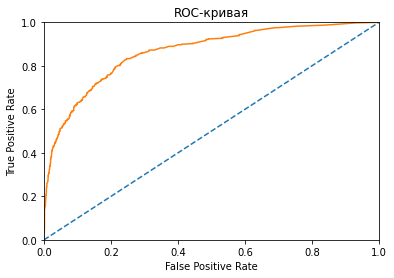

In [25]:
balanced_model = grid_hyp(df, coder='ordinal', balance='balanced')

Балансировка прошла зря

### Увеличение выборки

Подберем нужный коэфециент увеличения выборки и используем предусмотренный ранее параметр для увеличения выборки в функции подбора гиперпараметров:

In [26]:
features_train, target_train = coded_splitter(df, part='train', coder='ohe')
features_valid, target_valid = coded_splitter(df, part='valid', coder='ohe')
features_test, target_test = coded_splitter(df, part='test', coder='ohe')

In [27]:
target_train.value_counts()

0    4778
1    1222
Name: exited, dtype: int64

достаточно будет увеличить количесто положительных ответов в 4 раза:

Лучшие параметры: {'n_estimators': 96, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False} 
 confusion_matrix 
 [[1528   64]
 [ 218  190]] 
 F1 на этой моделе: 0.5740181268882175 
 AUC_ROC: 0.8512430411863238


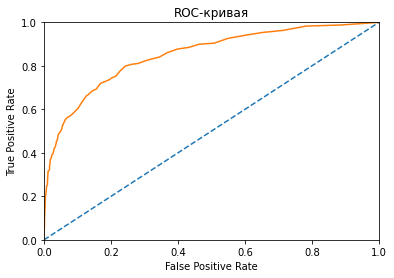

In [28]:
up_model = grid_hyp(df, coder='ordinal', balance=None, sample=4)

f1 все еще деградирует по сравнению с первоначальным вариантом

### Уменьшение выборки

Лучшие параметры: {'n_estimators': 28, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 34, 'bootstrap': True} 
 confusion_matrix 
 [[1315  277]
 [ 101  307]] 
 F1 на этой моделе: 0.6189516129032258 
 AUC_ROC: 0.8616597078529904


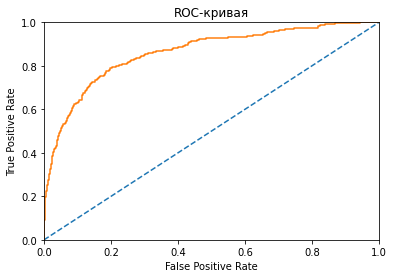

In [29]:
down_model = grid_hyp(df, coder='ordinal', balance=None, sample=0.3)

Удалось повысить f1 до 0,61. Принимаем эту модель в качестве лучшей

## Тестирование модели

In [35]:
final_model = down_model
features_test, target_test = \
grid_hyp(df, coder='ordinal', balance=None, sample=0.3, testing=True)

In [31]:
final_model

RandomForestClassifier(max_depth=34, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=12, n_estimators=28,
                       random_state=123456)

In [32]:
predicted_test = final_model.predict(features_test)    
result = f1_score(target_test, predicted_test)
print(
        'F1 на тестовой выборке:', result
)

F1 при балансировке классов: 0.5943775100401606


Успех! посмотрим что с Auc-roc и графиком:

AUC_ROC: 0.8423909271366897


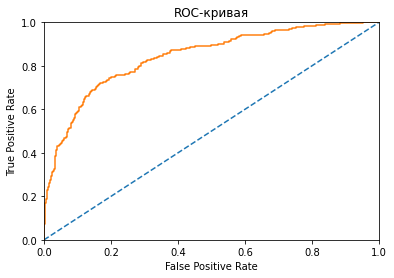

In [34]:
probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
auc_roc = roc_auc_score(target_test, probabilities_one_test)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.])
plt.xlim([0.0, 1])
plt.title("ROC-кривая")

print (
    'AUC_ROC:', auc_roc
)

В этой модели видим качественое улучшение площади под кривой на равне с увеличением f1 меры в рамках нужного. Выбраная модель случайного леса, с подобранными гиперпараметрами случайным поиском показывает наилучший результат при использовании даунсеплинга и может быть применена для прогнозирования оттока клиентов в нашей задаче.  